# Arttırılmış Asma Hastalığı Sınıflandırması

## 📌 Introduction
"""
Problem: Classify grapevine leaf diseases using image data.

In this project, we aim to classify grapevine leaves into four categories using a Deep Convolutional Neural Network (CNN):
- Black Rot
- ESCA
- Healthy
- Leaf Blight

We will build the CNN from scratch using TensorFlow/Keras, without any transfer learning, recurrent layers, or generative models.
The model will learn to distinguish between disease types from images captured under field and lab conditions.


In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


## 📊 Analysis

Veri setini anlamaya çalışıyoruz. Önce klasörlere bakıyoruz, sonra her sınıftan bir görsel gösteriyoruz.
Görsellerin boyutlarını analiz edip, bir örnek görselin renk histogramını çıkarıyoruz.
Bu sayede modelden önce veriyi tanımış oluyoruz.


In [2]:
#Kütüphaneleri Yükle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from collections import Counter
import matplotlib.image as mpimg

In [3]:
# Dataset yolunu belirt
base_path = "3-Augmented Grapevine Disease Dataset"
classes = os.listdir(base_path)
print("Sınıflar:", classes)

Sınıflar: ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']


In [4]:
# Sınıf başına görsel sayısı
counts = {}
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    counts[cls] = len(os.listdir(cls_path))
    print(f"{cls}: {counts[cls]} görsel")

Black Rot: 3000 görsel
ESCA: 3000 görsel
Healthy: 3000 görsel
Leaf Blight: 3000 görsel


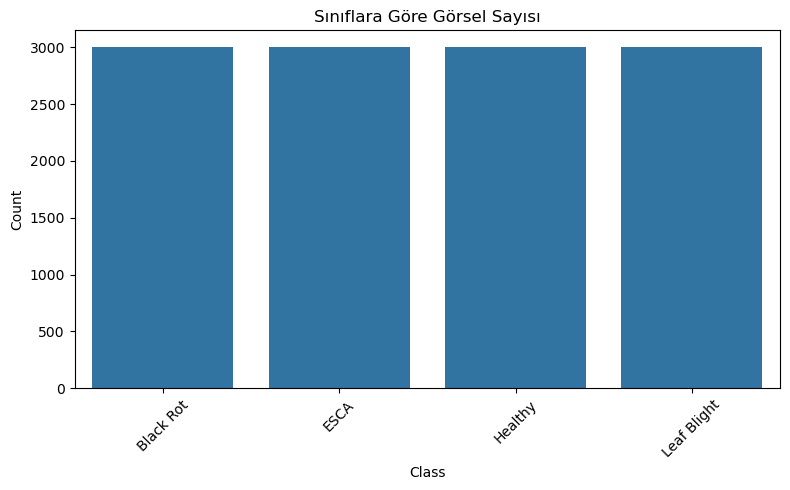

In [5]:
# Bar grafiği ile göster
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])
plt.figure(figsize=(8,5))
sns.barplot(data=df_counts, x="Class", y="Count")
plt.title("Sınıflara Göre Görsel Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

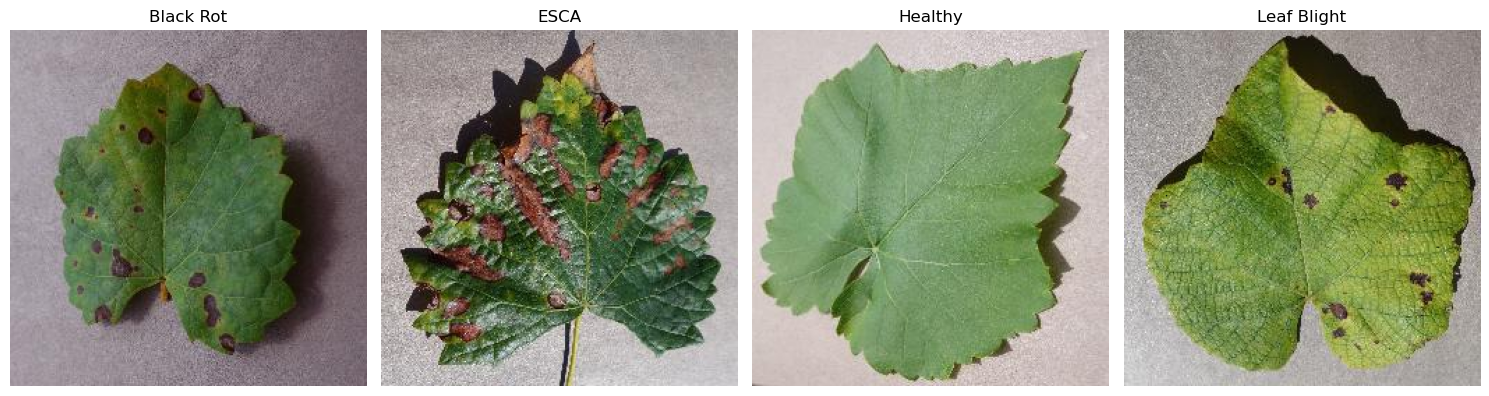

In [6]:
# Örnek görseller
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    img_path = os.path.join(base_path, cls, os.listdir(os.path.join(base_path, cls))[0])
    img = mpimg.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Görsel boyut analizi
all_shapes = []
for cls in classes:
    for file in os.listdir(os.path.join(base_path, cls)):
        img = Image.open(os.path.join(base_path, cls, file))
        all_shapes.append(img.size)

In [8]:
print("\n📐 Görsel Boyutları:")
shape_counts = Counter(all_shapes)
for shape, count in shape_counts.items():
    print(f"Boyut: {shape}, Adet: {count}")


📐 Görsel Boyutları:
Boyut: (256, 256), Adet: 6616
Boyut: (224, 224), Adet: 5384


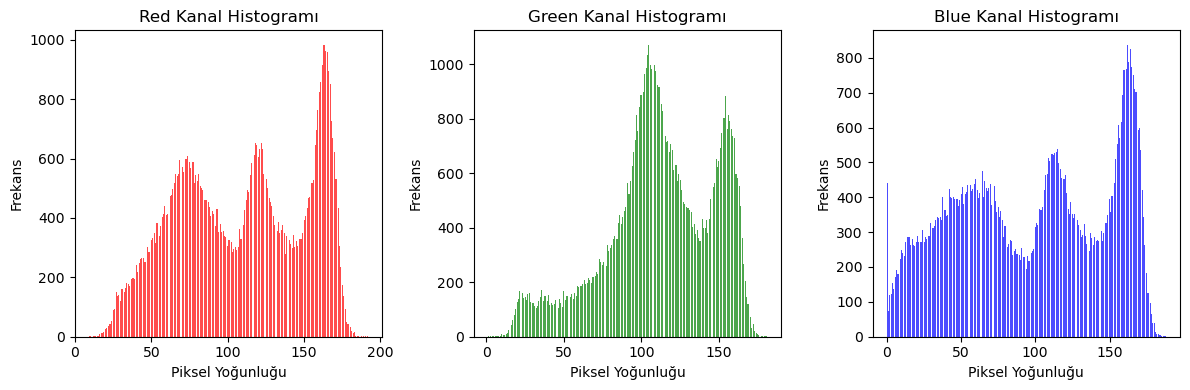

In [9]:
# Örnek bir görselin histogramı
sample_img_path = os.path.join(base_path, classes[0], os.listdir(os.path.join(base_path, classes[0]))[0])
sample_img = Image.open(sample_img_path)
sample_np = np.array(sample_img)

plt.figure(figsize=(12, 4))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i+1)
    plt.hist(sample_np[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.7)
    plt.title(f"{color} Kanal Histogramı")
    plt.xlabel("Piksel Yoğunluğu")
    plt.ylabel("Frekans")
plt.tight_layout()
plt.show()

### ⚙️ Methods

Bu bölümde veri ön işleme (augmentasyon) ve CNN modelini oluşturuyoruz.
- Görselleri yeniden boyutlandırıyoruz.
- Augmentasyonla modeli daha dayanıklı hale getiriyoruz.
- Model mimarisi: 5 Conv + 3 Pool katmanı + Dropout + BatchNormalization içeriyor.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [11]:
img_size = (150, 150)
batch_size = 32

total_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = total_datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = total_datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_indices = train_generator.class_indices
print("\nSınıf İndeksleri:", class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.

Sınıf İndeksleri: {'Black Rot': 0, 'ESCA': 1, 'Healthy': 2, 'Leaf Blight': 3}


C:\Users\MucahitYumusakT\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,257,668 (20.06 MB)

 Trainable params: 5,257,412 (20.06 MB)

 Non-trainable params: 256 (1.00 KB)

### 📈 Results

Modeli eğitiyoruz ve eğitim/validasyon sonuçlarını değerlendiriyoruz.
- EarlyStopping ile aşırı öğrenmeyi engelliyoruz.
- ModelCheckpoint ile en iyi modeli kaydediyoruz.
- Eğitim sonrası grafiklerle başarımı görselleştiriyoruz.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_grape_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

C:\Users\MucahitYumusakT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6950 - loss: 0.7199  

300/300 ━━━━━━━━━━━━━━━━━━━━ 170s 552ms/step - accuracy: 0.6953 - loss: 0.7192 - val_accuracy: 0.8213 - val_loss: 0.8604
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8809 - loss: 0.3173  

300/300 ━━━━━━━━━━━━━━━━━━━━ 171s 570ms/step - accuracy: 0.8810 - loss: 0.3172 - val_accuracy: 0.8321 - val_loss: 0.4020
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 174s 581ms/step - accuracy: 0.9356 - loss: 0.1810 - val_accuracy: 0.7904 - val_loss: 0.5752
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9472 - loss: 0.1586  

300/300 ━━━━━━━━━━━━━━━━━━━━ 226s 753ms/step - accuracy: 0.9472 - loss: 0.1586 - val_accuracy: 0.9508 - val_loss: 0.1429
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9643 - loss: 0.1094  

300/300 ━━━━━━━━━━━━━━━━━━━━ 229s 762ms/step - accuracy: 0.9643 - loss: 0.1094 - val_accuracy: 0.9563 - val_loss: 0.1353
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 165s 549ms/step - accuracy: 0.9687 - loss: 0.0920 - val_accuracy: 0.9237 - val_loss: 0.2592
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9729 - loss: 0.0732  

300/300 ━━━━━━━━━━━━━━━━━━━━ 174s 581ms/step - accuracy: 0.9729 - loss: 0.0732 - val_accuracy: 0.9733 - val_loss: 0.0870
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 165s 549ms/step - accuracy: 0.9767 - loss: 0.0673 - val_accuracy: 0.8279 - val_loss: 0.5284
Epoch 9/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 173s 577ms/step - accuracy: 0.9808 - loss: 0.0556 - val_accuracy: 0.9104 - val_loss: 0.2366
Epoch 10/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 178s 592ms/step - accuracy: 0.9792 - loss: 0.0613 - val_accuracy: 0.8904 - val_loss: 0.3578
Epoch 11/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9836 - loss: 0.0463  

300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 504ms/step - accuracy: 0.9836 - loss: 0.0464 - val_accuracy: 0.9688 - val_loss: 0.0791
Epoch 12/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 150s 502ms/step - accuracy: 0.9868 - loss: 0.0390 - val_accuracy: 0.9717 - val_loss: 0.0797
Epoch 13/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9833 - loss: 0.0564  

300/300 ━━━━━━━━━━━━━━━━━━━━ 155s 517ms/step - accuracy: 0.9833 - loss: 0.0564 - val_accuracy: 0.9754 - val_loss: 0.0694
Epoch 14/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 152s 506ms/step - accuracy: 0.9873 - loss: 0.0381 - val_accuracy: 0.8579 - val_loss: 0.5078
Epoch 15/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 161s 535ms/step - accuracy: 0.9842 - loss: 0.0555 - val_accuracy: 0.9546 - val_loss: 0.1276
Epoch 16/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 153s 508ms/step - accuracy: 0.9873 - loss: 0.0392 - val_accuracy: 0.9708 - val_loss: 0.0776
Epoch 17/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9893 - loss: 0.0322  

300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 503ms/step - accuracy: 0.9893 - loss: 0.0322 - val_accuracy: 0.9875 - val_loss: 0.0363
Epoch 18/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 154s 513ms/step - accuracy: 0.9892 - loss: 0.0343 - val_accuracy: 0.9825 - val_loss: 0.0519
Epoch 19/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 154s 513ms/step - accuracy: 0.9915 - loss: 0.0265 - val_accuracy: 0.8338 - val_loss: 0.4849
Epoch 20/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 156s 521ms/step - accuracy: 0.9934 - loss: 0.0260 - val_accuracy: 0.9696 - val_loss: 0.0925


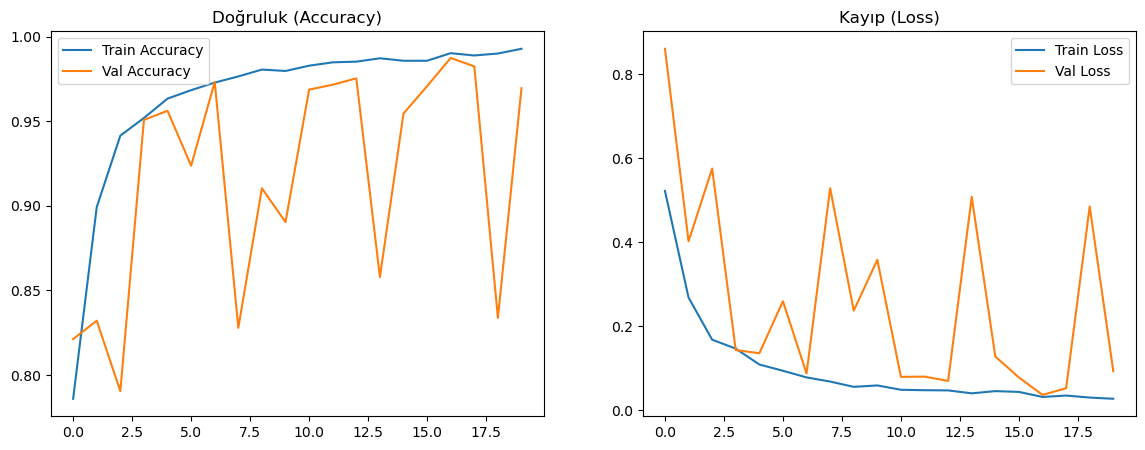

In [15]:
# Eğitim grafikleri
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Doğruluk (Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Kayıp (Loss)')
plt.show()

In [16]:
model.save('GVineCNN_model.h5')

## 💬 Reflection


Bu projede sıfırdan bir CNN modeli oluşturarak üzüm yaprağı hastalıklarını sınıflandırdık. 
Veri setinin dengeli olması ve augmentasyon yöntemleri modelimizin genelleme gücünü artırdı.

Özellikle Dropout ve BatchNormalization katmanları sayesinde overfitting önemli ölçüde engellendi.
EarlyStopping ve ModelCheckpoint callback'leri eğitim sürecini daha kontrollü hale getirdi.

Bazı sınıflarda yüksek başarı elde edilirken, benzer görsellere sahip hastalıklarda karışıklıklar yaşandı. 
Bu, daha fazla veri ile veya transfer learning yöntemleriyle geliştirilebilir.

Gelecekte, daha büyük veri kümeleri ile önceden eğitilmiş ağlar (örneğin ResNet50) kullanarak doğruluğu artırmayı hedefleyebiliriz.
